<a href="https://colab.research.google.com/github/Ibrahim341998/Face_recognition_using_mtcnn/blob/main/face_recognition_for_Mpuza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial recognition for Mpuza**

In [ ]:
#Import dependencies
import hashlib # encryption and decryption of messages
import os 
import shutil # for copy and paste purpose
import sys
import tempfile # for creating temporary files and folder
from PIL import Image, ImageDraw, ImageFont # for imageprocessing capabilities

from tqdm.auto import tqdm
from urllib.request import urlopen, Request

import requests
from requests.adapters import HTTPAdapter

import torch
from torch import nn # for neural network

import numpy as np
import os
from time import time

from torch.nn.functional import interpolate
from torchvision.ops.boxes import batched_nms
import math

try:
    import cv2
except:
    pass

from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Mounting from G-Drive


In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''
!unzip /content/drive/MyDrive/Mpuza_project.zip

Archive:  /content/drive/MyDrive/Mpuza_project.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/faceRecog.pt       
  inflating: __MACOSX/data/._faceRecog.pt  
  inflating: data/Final_Year_Project.png  
  inflating: __MACOSX/data/._Final_Year_Project.png  
  inflating: data/font.ttf           
  inflating: __MACOSX/data/._font.ttf  
   creating: data/test_demo/
  inflating: __MACOSX/data/._test_demo  
  inflating: data/onet.pt            
  inflating: __MACOSX/data/._onet.pt  
  inflating: data/rnet.pt            
  inflating: __MACOSX/data/._rnet.pt  
  inflating: data/pnet.pt            
  inflating: __MACOSX/data/._pnet.pt  
   creating: data/test_demo/database/
  inflating: __MACOSX/data/test_demo/._database  
  inflating: data/test_demo/.DS_Store  
  inflating: __MACOSX/data/test_demo/._.DS_Store  
  inflating: data/test_demo/database/.DS_Store  
  inflating: __MACOSX/data/

In [ ]:
class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) # verify bias false"
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, # value found in tensorflow
            momentum=0.1, # default pytorch value
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Model(nn.Module):

    def __init__(self, pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None):
        super().__init__()

        # Set simple attributes
        self.pretrained = pretrained
        self.classify = classify
        self.num_classes = num_classes

        if pretrained == True:
            tmp_classes = 8631
        elif pretrained is None and self.classify and self.num_classes is None:
            raise Exception('If "pretrained" is not specified and "classify" is True, "num_classes" must be specified')


        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 512, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)

        if pretrained is not None:
            self.logits = nn.Linear(512, tmp_classes)
            load_weights(self, pretrained)

        if self.classify and self.num_classes is not None:
            self.logits = nn.Linear(512, self.num_classes)

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):

        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
        x = self.last_bn(x)
        if self.classify:
            x = self.logits(x)
        else:
            from torch.nn import functional as F
            x = F.normalize(x, p=2, dim=1)
        return x

def load_weights(mdl, pretrained):

    if pretrained == True:
        path = os.path.join('data', 'faceRecog.pt')
    else:
        raise ValueError('Pretrained models not found!"')

    model_dir = os.path.join(get_torch_home(), 'checkpoints')
    os.makedirs(model_dir, exist_ok=True)

    cached_file = os.path.join(model_dir, 'faceRecog.pt')

    if not os.path.exists(cached_file):
        shutil.copy2(path, model_dir)

    state_dict = torch.load(cached_file)
    mdl.load_state_dict(state_dict)

def get_torch_home():
    torch_home = os.path.expanduser(
        os.getenv(
            'TORCH_HOME',
            os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')
        )
    )
    return torch_home

# Util functions

In [ ]:
def fixed_batch_process(im_data, model):
    batch_size = 512
    out = []
    for i in range(0, len(im_data), batch_size):
        batch = im_data[i:(i+batch_size)]
        out.append(model(batch))

    return tuple(torch.cat(v, dim=0) for v in zip(*out))

def detect_face(imgs, minsize, pnet, rnet, onet, threshold, factor, device):
    if isinstance(imgs, (np.ndarray, torch.Tensor)):
        if isinstance(imgs,np.ndarray):
            imgs = torch.as_tensor(imgs.copy(), device=device)

        if isinstance(imgs,torch.Tensor):
            imgs = torch.as_tensor(imgs, device=device)

        if len(imgs.shape) == 3:
            imgs = imgs.unsqueeze(0)
    else:
        if not isinstance(imgs, (list, tuple)):
            imgs = [imgs]
        if any(img.size != imgs[0].size for img in imgs):
            raise Exception("MTCNN batch processing only compatible with equal-dimension images.")
        imgs = np.stack([np.uint8(img) for img in imgs])
        imgs = torch.as_tensor(imgs.copy(), device=device)

    

    model_dtype = next(pnet.parameters()).dtype
    imgs = imgs.permute(0, 3, 1, 2).type(model_dtype)

    batch_size = len(imgs)
    h, w = imgs.shape[2:4]
    m = 12.0 / minsize
    minl = min(h, w)
    minl = minl * m

    # Create scale pyramid
    scale_i = m
    scales = []
    while minl >= 12:
        scales.append(scale_i)
        scale_i = scale_i * factor
        minl = minl * factor

    # First stage
    boxes = []
    image_inds = []

    scale_picks = []

    all_i = 0
    offset = 0
    for scale in scales:
        im_data = imresample(imgs, (int(h * scale + 1), int(w * scale + 1)))
        im_data = (im_data - 127.5) * 0.0078125
        reg, probs = pnet(im_data)
    
        boxes_scale, image_inds_scale = generateBoundingBox(reg, probs[:, 1], scale, threshold[0])
        boxes.append(boxes_scale)
        image_inds.append(image_inds_scale)

        pick = batched_nms(boxes_scale[:, :4], boxes_scale[:, 4], image_inds_scale, 0.5)
        scale_picks.append(pick + offset)
        offset += boxes_scale.shape[0]

    boxes = torch.cat(boxes, dim=0)
    image_inds = torch.cat(image_inds, dim=0)

    scale_picks = torch.cat(scale_picks, dim=0)

    # NMS within each scale + image
    boxes, image_inds = boxes[scale_picks], image_inds[scale_picks]


    # NMS within each image
    pick = batched_nms(boxes[:, :4], boxes[:, 4], image_inds, 0.7)
    boxes, image_inds = boxes[pick], image_inds[pick]

    regw = boxes[:, 2] - boxes[:, 0]
    regh = boxes[:, 3] - boxes[:, 1]
    qq1 = boxes[:, 0] + boxes[:, 5] * regw
    qq2 = boxes[:, 1] + boxes[:, 6] * regh
    qq3 = boxes[:, 2] + boxes[:, 7] * regw
    qq4 = boxes[:, 3] + boxes[:, 8] * regh
    boxes = torch.stack([qq1, qq2, qq3, qq4, boxes[:, 4]]).permute(1, 0)
    boxes = rerec(boxes)
    y, ey, x, ex = pad(boxes, w, h)
    
    # Second stage
    if len(boxes) > 0:
        im_data = []
        for k in range(len(y)):
            if ey[k] > (y[k] - 1) and ex[k] > (x[k] - 1):
                img_k = imgs[image_inds[k], :, (y[k] - 1):ey[k], (x[k] - 1):ex[k]].unsqueeze(0)
                im_data.append(imresample(img_k, (24, 24)))
        im_data = torch.cat(im_data, dim=0)
        im_data = (im_data - 127.5) * 0.0078125

        # This is equivalent to out = rnet(im_data) to avoid GPU out of memory.
        out = fixed_batch_process(im_data, rnet)

        out0 = out[0].permute(1, 0)
        out1 = out[1].permute(1, 0)
        score = out1[1, :]
        ipass = score > threshold[1]
        boxes = torch.cat((boxes[ipass, :4], score[ipass].unsqueeze(1)), dim=1)
        image_inds = image_inds[ipass]
        mv = out0[:, ipass].permute(1, 0)

        # NMS within each image
        pick = batched_nms(boxes[:, :4], boxes[:, 4], image_inds, 0.7)
        boxes, image_inds, mv = boxes[pick], image_inds[pick], mv[pick]
        boxes = bbreg(boxes, mv)
        boxes = rerec(boxes)

    # Third stage
    points = torch.zeros(0, 5, 2, device=device)
    if len(boxes) > 0:
        y, ey, x, ex = pad(boxes, w, h)
        im_data = []
        for k in range(len(y)):
            if ey[k] > (y[k] - 1) and ex[k] > (x[k] - 1):
                img_k = imgs[image_inds[k], :, (y[k] - 1):ey[k], (x[k] - 1):ex[k]].unsqueeze(0)
                im_data.append(imresample(img_k, (48, 48)))
        im_data = torch.cat(im_data, dim=0)
        im_data = (im_data - 127.5) * 0.0078125
        
        # This is equivalent to out = onet(im_data) to avoid GPU out of memory.
        out = fixed_batch_process(im_data, onet)

        out0 = out[0].permute(1, 0)
        out1 = out[1].permute(1, 0)
        out2 = out[2].permute(1, 0)
        score = out2[1, :]
        points = out1
        ipass = score > threshold[2]
        points = points[:, ipass]
        boxes = torch.cat((boxes[ipass, :4], score[ipass].unsqueeze(1)), dim=1)
        image_inds = image_inds[ipass]
        mv = out0[:, ipass].permute(1, 0)

        w_i = boxes[:, 2] - boxes[:, 0] + 1
        h_i = boxes[:, 3] - boxes[:, 1] + 1
        points_x = w_i.repeat(5, 1) * points[:5, :] + boxes[:, 0].repeat(5, 1) - 1
        points_y = h_i.repeat(5, 1) * points[5:10, :] + boxes[:, 1].repeat(5, 1) - 1
        points = torch.stack((points_x, points_y)).permute(2, 1, 0)
        boxes = bbreg(boxes, mv)

        # NMS within each image using "Min" strategy
        # pick = batched_nms(boxes[:, :4], boxes[:, 4], image_inds, 0.7)
        pick = batched_nms_numpy(boxes[:, :4], boxes[:, 4], image_inds, 0.7, 'Min')
        boxes, image_inds, points = boxes[pick], image_inds[pick], points[pick]

    boxes = boxes.cpu().numpy()
    points = points.cpu().numpy()

    image_inds = image_inds.cpu()

    batch_boxes = []
    batch_points = []
    for b_i in range(batch_size):
        b_i_inds = np.where(image_inds == b_i)
        batch_boxes.append(boxes[b_i_inds].copy())
        batch_points.append(points[b_i_inds].copy())

    batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)

    return batch_boxes, batch_points


def bbreg(boundingbox, reg):
    if reg.shape[1] == 1:
        reg = torch.reshape(reg, (reg.shape[2], reg.shape[3]))

    w = boundingbox[:, 2] - boundingbox[:, 0] + 1
    h = boundingbox[:, 3] - boundingbox[:, 1] + 1
    b1 = boundingbox[:, 0] + reg[:, 0] * w
    b2 = boundingbox[:, 1] + reg[:, 1] * h
    b3 = boundingbox[:, 2] + reg[:, 2] * w
    b4 = boundingbox[:, 3] + reg[:, 3] * h
    boundingbox[:, :4] = torch.stack([b1, b2, b3, b4]).permute(1, 0)

    return boundingbox


def generateBoundingBox(reg, probs, scale, thresh):
    stride = 2
    cellsize = 12

    reg = reg.permute(1, 0, 2, 3)

    mask = probs >= thresh
    mask_inds = mask.nonzero()
    image_inds = mask_inds[:, 0]
    score = probs[mask]
    reg = reg[:, mask].permute(1, 0)
    bb = mask_inds[:, 1:].type(reg.dtype).flip(1)
    q1 = ((stride * bb + 1) / scale).floor()
    q2 = ((stride * bb + cellsize - 1 + 1) / scale).floor()
    boundingbox = torch.cat([q1, q2, score.unsqueeze(1), reg], dim=1)
    return boundingbox, image_inds


def nms_numpy(boxes, scores, threshold, method):
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0].copy()
    y1 = boxes[:, 1].copy()
    x2 = boxes[:, 2].copy()
    y2 = boxes[:, 3].copy()
    s = scores
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    I = np.argsort(s)
    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while I.size > 0:
        i = I[-1]
        pick[counter] = i
        counter += 1
        idx = I[0:-1]

        xx1 = np.maximum(x1[i], x1[idx]).copy()
        yy1 = np.maximum(y1[i], y1[idx]).copy()
        xx2 = np.minimum(x2[i], x2[idx]).copy()
        yy2 = np.minimum(y2[i], y2[idx]).copy()

        w = np.maximum(0.0, xx2 - xx1 + 1).copy()
        h = np.maximum(0.0, yy2 - yy1 + 1).copy()

        inter = w * h
        if method is "Min":
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)
        I = I[np.where(o <= threshold)]

    pick = pick[:counter].copy()
    return pick


def batched_nms_numpy(boxes, scores, idxs, threshold, method):
    device = boxes.device
    if boxes.numel() == 0:
        return torch.empty((0,), dtype=torch.int64, device=device)

    max_coordinate = boxes.max()
    offsets = idxs.to(boxes) * (max_coordinate + 1)
    boxes_for_nms = boxes + offsets[:, None]
    boxes_for_nms = boxes_for_nms.cpu().numpy()
    scores = scores.cpu().numpy()
    keep = nms_numpy(boxes_for_nms, scores, threshold, method)
    return torch.as_tensor(keep, dtype=torch.long, device=device)


def pad(boxes, w, h):
    boxes = boxes.trunc().int().cpu().numpy()
    x = boxes[:, 0]
    y = boxes[:, 1]
    ex = boxes[:, 2]
    ey = boxes[:, 3]

    x[x < 1] = 1
    y[y < 1] = 1
    ex[ex > w] = w
    ey[ey > h] = h

    return y, ey, x, ex


def rerec(bboxA):
    h = bboxA[:, 3] - bboxA[:, 1]
    w = bboxA[:, 2] - bboxA[:, 0]
    
    l = torch.max(w, h)
    bboxA[:, 0] = bboxA[:, 0] + w * 0.5 - l * 0.5
    bboxA[:, 1] = bboxA[:, 1] + h * 0.5 - l * 0.5
    bboxA[:, 2:4] = bboxA[:, :2] + l.repeat(2, 1).permute(1, 0)

    return bboxA


def imresample(img, sz):
    im_data = interpolate(img, size=sz, mode="area")
    return im_data


def crop_resize(img, box, image_size):
    if isinstance(img, np.ndarray):
        img = img[box[1]:box[3], box[0]:box[2]]
        out = cv2.resize(
            img,
            (image_size, image_size),
            interpolation=cv2.INTER_AREA
        ).copy()
    elif isinstance(img, torch.Tensor):
        img = img[box[1]:box[3], box[0]:box[2]]
        out = imresample(
            img.permute(2, 0, 1).unsqueeze(0).float(),
            (image_size, image_size)
        ).byte().squeeze(0).permute(1, 2, 0)
    else:
        out = img.crop(box).copy().resize((image_size, image_size), Image.BILINEAR)
    return out


def save_img(img, path):
    if isinstance(img, np.ndarray):
        cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    else:
        img.save(path)


def get_size(img):
    if isinstance(img, (np.ndarray, torch.Tensor)):
        return img.shape[1::-1]
    else:
        return img.size


def extract_face(img, box, image_size=160, margin=0, save_path=None):

    from torchvision.transforms import functional as F

    margin = [
        margin * (box[2] - box[0]) / (image_size - margin),
        margin * (box[3] - box[1]) / (image_size - margin),
    ]
    raw_image_size = get_size(img)
    box = [
        int(max(box[0] - margin[0] / 2, 0)),
        int(max(box[1] - margin[1] / 2, 0)),
        int(min(box[2] + margin[0] / 2, raw_image_size[0])),
        int(min(box[3] + margin[1] / 2, raw_image_size[1])),
    ]

    face = crop_resize(img, box, image_size)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path) + "/", exist_ok=True)
        save_img(face, save_path)

    face = F.to_tensor(np.float32(face))

    return face

def draw_bbox(img, face, name, similarity, threshold_recog):

    if similarity is not None and float(similarity) * 100 < threshold_recog:
        text = "NO MATCH"
        similarity = None
    else:
        text = '{0} {1:.2f}'.format(name.upper(), float(similarity) * 100)

    draw = ImageDraw.Draw(img)
    fs = max(20, round(img.size[0] * img.size[1] * 0.000005))

    font = ImageFont.truetype(os.path.join('data', 'font.ttf'), fs)
    margin = 5

    text_size = font.getsize(text)

    if text == 'NO MATCH':
        outline='red'
        fill='red'
        color='#FFFFFF'
        
    else:
        outline='green'
        fill='green'
        color='#00FF00'
        
    draw.rectangle(
                (
                    (int(face[0]), int(face[1])),
                    (int(face[2]), int(face[3]))
                ),
                outline=outline,
                width=4
            )
    
    if text == 'NO MATCH':
        return

    draw.rectangle(
                (
                    (int(face[0]), int(face[3]) ),
                    (int(face[0] + text_size[0] + 8), int(face[3]) + text_size[1] + 5 )
                ),
                fill=fill
            )
        
    draw.text(
            (int(face[0])+ 2, int(face[3])),
            text,
            font=font, fill=color
        )
    
def batch_similarity(reference_embedding, test_embedding, reference_names):
    dotProduct = np.dot(reference_embeddings.cpu().numpy(), embeddings.cpu().numpy().T)
    similarity_idx = np.argmax(dotProduct, axis = 0)

    return [dotProduct[j][i] for i, j in enumerate(similarity_idx)], [reference_names[i] for i in similarity_idx]

# Face Detection Model

In [ ]:
class PNet(nn.Module):

    def __init__(self, pretrained=True):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.prelu1 = nn.PReLU(10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=3)
        self.prelu2 = nn.PReLU(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.prelu3 = nn.PReLU(32)
        self.conv4_1 = nn.Conv2d(32, 2, kernel_size=1)
        self.softmax4_1 = nn.Softmax(dim=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1)

        self.training = False

        if pretrained:
            state_dict_path = os.path.join('data', 'pnet.pt')
            state_dict = torch.load(state_dict_path)
            self.load_state_dict(state_dict)

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        a = self.conv4_1(x)
        a = self.softmax4_1(a)
        b = self.conv4_2(x)
        return b, a


class RNet(nn.Module):

    def __init__(self, pretrained=True):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 28, kernel_size=3)
        self.prelu1 = nn.PReLU(28)
        self.pool1 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(28, 48, kernel_size=3)
        self.prelu2 = nn.PReLU(48)
        self.pool2 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=2)
        self.prelu3 = nn.PReLU(64)
        self.dense4 = nn.Linear(576, 128)
        self.prelu4 = nn.PReLU(128)
        self.dense5_1 = nn.Linear(128, 2)
        self.softmax5_1 = nn.Softmax(dim=1)
        self.dense5_2 = nn.Linear(128, 4)

        self.training = False

        if pretrained:
            state_dict_path = os.path.join('data', 'rnet.pt')
            state_dict = torch.load(state_dict_path)
            self.load_state_dict(state_dict)

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.dense4(x.view(x.shape[0], -1))
        x = self.prelu4(x)
        a = self.dense5_1(x)
        a = self.softmax5_1(a)
        b = self.dense5_2(x)
        return b, a


class ONet(nn.Module):

    def __init__(self, pretrained=True):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.prelu1 = nn.PReLU(32)
        self.pool1 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.prelu2 = nn.PReLU(64)
        self.pool2 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.prelu3 = nn.PReLU(64)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.prelu4 = nn.PReLU(128)
        self.dense5 = nn.Linear(1152, 256)
        self.prelu5 = nn.PReLU(256)
        self.dense6_1 = nn.Linear(256, 2)
        self.softmax6_1 = nn.Softmax(dim=1)
        self.dense6_2 = nn.Linear(256, 4)
        self.dense6_3 = nn.Linear(256, 10)

        self.training = False

        if pretrained:
            state_dict_path = os.path.join('data', 'onet.pt')
            state_dict = torch.load(state_dict_path)
            self.load_state_dict(state_dict)

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.prelu4(x)
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.dense5(x.view(x.shape[0], -1))
        x = self.prelu5(x)
        a = self.dense6_1(x)
        a = self.softmax6_1(a)
        b = self.dense6_2(x)
        c = self.dense6_3(x)
        return b, c, a


class MTCNN(nn.Module):

    def __init__(
        self, image_size=160, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        select_largest=True, selection_method=None, keep_all=False, device=None
    ):
        super().__init__()

        self.image_size = image_size
        self.margin = margin
        self.min_face_size = min_face_size
        self.thresholds = thresholds
        self.factor = factor
        self.post_process = post_process
        self.select_largest = select_largest
        self.keep_all = keep_all
        self.selection_method = selection_method

        self.pnet = PNet()
        self.rnet = RNet()
        self.onet = ONet()

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

        if not self.selection_method:
            self.selection_method = 'largest' if self.select_largest else 'probability'

    def forward(self, img, save_path=None, return_prob=False):

        # Detect faces
        batch_boxes, batch_probs, batch_points = self.detect(img, landmarks=True)
        # Select faces
        if not self.keep_all:
            batch_boxes, batch_probs, batch_points = self.select_boxes(
                batch_boxes, batch_probs, batch_points, img, method=self.selection_method
            )
        # Extract faces
        faces = self.extract(img, batch_boxes, save_path)

        if return_prob:
            return faces, batch_probs, batch_boxes
        else:
            return faces

    def detect(self, img, landmarks=False):

        with torch.no_grad():
            batch_boxes, batch_points = detect_face(
                img, self.min_face_size,
                self.pnet, self.rnet, self.onet,
                self.thresholds, self.factor,
                self.device
            )

        boxes, probs, points = [], [], []
        for box, point in zip(batch_boxes, batch_points):
            box = np.array(box)
            point = np.array(point)
            if len(box) == 0:
                boxes.append(None)
                probs.append([None])
                points.append(None)
            elif self.select_largest:
                box_order = np.argsort((box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1]))[::-1]
                box = box[box_order]
                point = point[box_order]
                boxes.append(box[:, :4])
                probs.append(box[:, 4])
                points.append(point)
            else:
                boxes.append(box[:, :4])
                probs.append(box[:, 4])
                points.append(point)
        boxes = np.array(boxes)
        probs = np.array(probs)
        points = np.array(points)

        if (
            not isinstance(img, (list, tuple)) and 
            not (isinstance(img, np.ndarray) and len(img.shape) == 4) and
            not (isinstance(img, torch.Tensor) and len(img.shape) == 4)
        ):
            boxes = boxes[0]
            probs = probs[0]
            points = points[0]

        if landmarks:
            return boxes, probs, points

        return boxes, probs

    def select_boxes(
        self, all_boxes, all_probs, all_points, imgs, method='probability', threshold=0.9,
        center_weight=2.0
    ):

        batch_mode = True
        if (
                not isinstance(imgs, (list, tuple)) and
                not (isinstance(imgs, np.ndarray) and len(imgs.shape) == 4) and
                not (isinstance(imgs, torch.Tensor) and len(imgs.shape) == 4)
        ):
            imgs = [imgs]
            all_boxes = [all_boxes]
            all_probs = [all_probs]
            all_points = [all_points]
            batch_mode = False

        selected_boxes, selected_probs, selected_points = [], [], []
        for boxes, points, probs, img in zip(all_boxes, all_points, all_probs, imgs):
            
            if boxes is None:
                selected_boxes.append(None)
                selected_probs.append([None])
                selected_points.append(None)
                continue
            
            # If at least 1 box found
            boxes = np.array(boxes)
            probs = np.array(probs)
            points = np.array(points)
                
            if method == 'largest':
                box_order = np.argsort((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))[::-1]
            elif method == 'probability':
                box_order = np.argsort(probs)[::-1]
            elif method == 'center_weighted_size':
                box_sizes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
                img_center = (img.width / 2, img.height/2)
                box_centers = np.array(list(zip((boxes[:, 0] + boxes[:, 2]) / 2, (boxes[:, 1] + boxes[:, 3]) / 2)))
                offsets = box_centers - img_center
                offset_dist_squared = np.sum(np.power(offsets, 2.0), 1)
                box_order = np.argsort(box_sizes - offset_dist_squared * center_weight)[::-1]
            elif method == 'largest_over_threshold':
                box_mask = probs > threshold
                boxes = boxes[box_mask]
                box_order = np.argsort((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))[::-1]
                if sum(box_mask) == 0:
                    selected_boxes.append(None)
                    selected_probs.append([None])
                    selected_points.append(None)
                    continue

            box = boxes[box_order][[0]]
            prob = probs[box_order][[0]]
            point = points[box_order][[0]]
            selected_boxes.append(box)
            selected_probs.append(prob)
            selected_points.append(point)

        if batch_mode:
            selected_boxes = np.array(selected_boxes)
            selected_probs = np.array(selected_probs)
            selected_points = np.array(selected_points)
        else:
            selected_boxes = selected_boxes[0]
            selected_probs = selected_probs[0][0]
            selected_points = selected_points[0]

        return selected_boxes, selected_probs, selected_points

    def extract(self, img, batch_boxes, save_path):
        # Determine if a batch or single image was passed
        batch_mode = True
        if (
                not isinstance(img, (list, tuple)) and
                not (isinstance(img, np.ndarray) and len(img.shape) == 4) and
                not (isinstance(img, torch.Tensor) and len(img.shape) == 4)
        ):
            img = [img]
            batch_boxes = [batch_boxes]
            batch_mode = False

        # Parse save path(s)
        if save_path is not None:
            if isinstance(save_path, str):
                save_path = [save_path]
        else:
            save_path = [None for _ in range(len(img))]

        # Process all bounding boxes
        faces = []
        for im, box_im, path_im in zip(img, batch_boxes, save_path):
            if box_im is None:
                faces.append(None)
                continue

            if not self.keep_all:
                box_im = box_im[[0]]

            faces_im = []
            for i, box in enumerate(box_im):
                face_path = path_im
                if path_im is not None and i > 0:
                    save_name, ext = os.path.splitext(path_im)
                    face_path = save_name + '_' + str(i + 1) + ext

                face = extract_face(im, box, self.image_size, self.margin, face_path)
                if self.post_process:
                    face = fixed_image_standardization(face)
                faces_im.append(face)

            if self.keep_all:
                faces_im = torch.stack(faces_im)
            else:
                faces_im = faces_im[0]

            faces.append(faces_im)

        if not batch_mode:
            faces = faces[0]

        return faces


def fixed_image_standardization(image_tensor):
    processed_tensor = (image_tensor - 127.5) / 128.0
    return processed_tensor


def prewhiten(x):
    mean = x.mean()
    std = x.std()
    std_adj = std.clamp(min=1.0/(float(x.numel())**0.5))
    y = (x - mean) / std_adj
    return y

# Device

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


cuda: #, means we are using a GPU runtime

cpu, means we are on CPU runtime

## Loading the Pre-trained model

In [ ]:
resnet = Model(pretrained=True).eval().to(device)
print(f"Face Recognition model Summary: {len(list(resnet.modules()))} layers, {sum(x.numel() for x in resnet.parameters())} parameters")

Face Recognition model Summary: 550 layers, 27910327 parameters


## Reference Database (run the cell twice if exception kicks in)

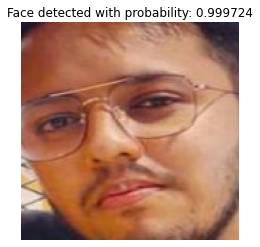

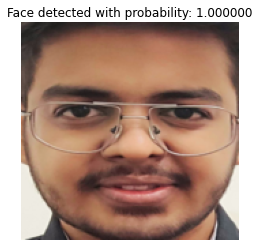

In [ ]:
def collate_fn(x):
    return x[0]

try:
    os.system('rm -r data/test_demo/database/.ipynb_checkpoints')
except:
    pass

try:
    dataset = datasets.ImageFolder(os.path.join('data', 'test_demo', 'database'))
    dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
    loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)
except:
    print("Error with the Reference Dataset!")

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.5, 0.6, 0.6], factor=0.509, post_process=True,
    device=device, keep_all=False
)

workers = 0 if os.name == 'nt' else 4

aligned = []
names = []
for x, y in loader:
    x_aligned, prob, bboxRef = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        plt.title('Face detected with probability: {:8f}'.format(prob))
        plt.imshow(((x_aligned+1)/2).permute(1, 2, 0))
        plt.axis('off')
        plt.show()
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

In [ ]:
reference_aligned = torch.stack(aligned).to(device)
reference_embeddings = resnet(reference_aligned).detach().cpu()

In [ ]:
print('Identities:', names)

Identities: ['Ibrahim Momin', 'Ketan Bansal']


Time Taken: 0.12947607040405273


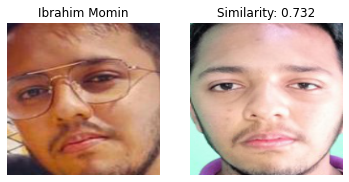


The processed image:



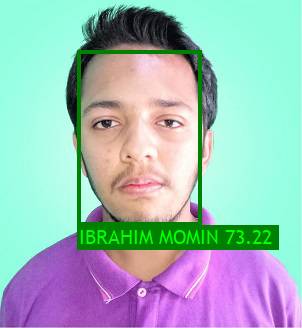

In [ ]:
test_image = Image.open("/content/Ibrahim Photo.JPG")

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.5, 0.6, 0.6], factor=0.509, post_process=True,
    device=device, keep_all=True
)

x_aligned, prob, bbox = mtcnn(test_image, return_prob=True)

if len(x_aligned.shape) == 3:
    x_aligned = x_aligned.unsqueeze(0)

aligned = x_aligned
aligned = aligned.to(device)

t1 = time()
embeddings = resnet(aligned).detach().cpu()
t2 = time()

print('Time Taken:', t2-t1)

similarity_idx, match_name = batch_similarity(reference_embeddings, embeddings, names)

for id_face, id_similarity, id_name, id_bbox in zip(x_aligned, similarity_idx, match_name, bbox):

    if id_similarity > 0.20:

        plt.figure(figsize = (6, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(((reference_aligned[names.index(id_name)] + 1)/2).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title(id_name)
        plt.subplot(1, 2, 2)
        plt.imshow(((id_face + 1)/2).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title(f'Similarity: {id_similarity:.3f}')
        plt.show()

    draw_bbox(test_image, id_bbox, id_name, id_similarity, threshold_recog=65)

print('\nThe processed image:\n')
display(test_image)